In [1]:
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import time as t

In [2]:
import pandas as pd
import sys
from env_pybullet_gen3 import env_pybullet_kin_gen3



In [3]:
#To improve the velocity, run it on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device ', device)



#Create a experiment env
env = env_pybullet_kin_gen3(no_zeros = True,Excel_path_Okay_tcp = "./positions_from_joints_19.xlsx",time_step=0.05,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

#Initially parameters of the urdf

#Make maxvels closer to the reality
#both have to be modified
env.max_vel = [168,151,128,94,210,48,189]
env.original_parameters_df ["max_vel"]=env.max_vel
print(env.original_parameters_df["max_vel"])
print(env.original_parameters_df)


print('observation space:', env.observation_space) #states, There is only 1 state constant
env.update_parameters_to_modify(["kp","ki","kd"])
print('action space:', env.action_space) #parameters, number of parameters choose to tune, continuous
print('original action:', env.action_original()) #parameters, number of parameters choose to tune, continuous




Device  cpu
hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
0    168
1    151
2    128
3     94
4    210
5     48
6    189
Name: max_vel, dtype: int64
       mass damping       Ixx       Iyy       Izz   kp   ki   kd  max_vel  \
0  1.377353       0  0.004801  0.004755  0.002283  0.1  0.0  0.0      168   
1  1.163667       0  0.008419  0.001920  0.008361  0.1  0.0  0.0      151   
2  1.163660       0  0.007545  0.007487  0.001921  0.1  0.0  0.0      128   
3  0.930287       0  0.006410  0.001380  0.006518  0.1  0.0  0.0       94   
4  0.678106       0  0.001680  0.001506  0.000826  0.1  0.0  0.0      210   
5  0.678106       0  0.001938  0.000827  0.001763  0.1  0.0  0.0       48   
6  0.500657       0  0.000775  0.000585  0.000975  0.1  0.0  0.0      189   

   force_x_one  
0            1  
1            1  
2            1  
3            1  
4            1  
5            1  
6            1  
observation space: 1
kp okey
ki okey
kd okey
act

In [4]:
#Cross Entrophy Method, to choose the weights

# In my case where only 1 action,and that it's apply the parameters do another step doesn't change anything due to the state doesn't vary
# For this reason max_t and gama doesn't make sense, so I set them to max_t = 1 and gamma to 0 ,sigma 0.05
def cem_no_net(n_iterations=900, max_t=1, gamma=0.0, print_every=50, pop_size=env.action_space*2, elite_frac=0.1, sigma=1.0,sigma_reduction_every_print = 0.65, per_one = True ):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
        per_one (boolean): to determine if the output is in per one or not
    """
    #Numbers of elements that you keep as the better ones
    n_elite=int(pop_size*elite_frac)
    
    #scores doble end queee , from iterations size * 0.1
    scores_deque = deque(maxlen=int(n_iterations*0.1))
    #intial scores empty
    scores = []
    #Save actions to see how they evolve
    best_actions = []
    #Select a seed to make the results the same every test, not depending on the seed
    np.random.seed(0)
    #Initial best weights, are from 0 to 1, it's good to be small the weights, but they should be different from 0.
    # small to avoid overfiting , different from 0 to update them
    
    if (per_one == True):
        best_weight = sigma*np.random.randn(env.action_space)
        original_action = np.array(env.action_original())
    else:
        best_weight = np.add(sigma*np.random.randn(env.action_space),env.action_original())

    #Each iteration, modify  + (from 0 to 1) the best weight randomly
    #Computes the reward with these weights
    #Sort the reward to get the best ones
    # Save the best weights
    # the Best weight it's the mean of the best one
    #compute the main reward of the main best rewards ones
    #this it's show to evalute how good its
    
    for i_iteration in range(1, n_iterations+1):
        
        #Generate new population weights, as a mutation of the best weight to test them
        weights_pop = [best_weight + (sigma*np.random.randn(env.action_space)) for i in range(pop_size)]
        
        #Compute the parameters and obtain the rewards for each of them
        #print("iteration "+str(i_iteration))
        if (per_one == True):
            rewards=[]
            for weights in weights_pop:
                #print("New weights")
                #print(weights)
                #t.sleep(1000)
                action=np.add(np.multiply(weights,original_action),original_action)
                rewards.append( env.step_tcp_rishabh(action) )
            rewards = np.array(rewards)
        else:
            rewards=[]
            for weights in weights_pop:
                rewards.append(env.step_tcp_rishabh(weights) )
            rewards = np.array(rewards)
        print("rewards" + str(i_iteration))
        #print(rewards)
        #print("\n")
        
        #Sort the rewards to obtain the best ones
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        
        #Set the best weight as the mean of the best ones 
       
        best_weight = np.array(elite_weights).mean(axis=0)
        
        #Get the reward with this new weight
        
        if (per_one == True):
            action = np.add(np.multiply(best_weight,original_action),original_action)
            #print("action vel")
            #print(action[8])
            #print("action kp")
            #print(action[15])
            #time.sleep(1000)
            best_actions.append(action)
            reward = env.step_tcp_rishabh(action)
            print("reward")
            print(reward)
            print("\n")
        else:
            best_actions.append(best_weight)
            reward = env.step_tcp_rishabh(best_weight)
        scores_deque.append(reward)
        scores.append(reward)
        
        #save the check point
        env.save_parameters("./Parameters_train_tcp_euc_rishabh.xlsx")
        
        if i_iteration % print_every == 0:
            sigma = sigma * sigma_reduction_every_print
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-n_iterations*0.1, np.mean(scores_deque)))
            break
    return scores,best_actions


rewards1
reward
-0.17657377085229217


rewards2
reward
-0.17968121321520883


rewards3
reward
-0.16054250780324536


rewards4
reward
-0.15879967137663378


rewards5
reward
-0.15635867338058254


rewards6
reward
-0.15260676161300255


rewards7
reward
-0.15173780475271173


rewards8
reward
-0.15220190297350011


rewards9
reward
-0.1513104799039677


rewards10
reward
-0.1514046183171087


rewards11
reward
-0.1506590084942892


rewards12
reward
-0.15077420537830338


rewards13
reward
-0.1499793957041691


rewards14
reward
-0.14964114837056833


rewards15
reward
-0.15019536827599178


rewards16
reward
-0.1495339666001771


rewards17
reward
-0.148915724897746


rewards18
reward
-0.1484739893856074


rewards19
reward
-0.14773761889476286


rewards20
reward
-0.14745874638477166


rewards21
reward
-0.1469766894400675


rewards22
reward
-0.14592413008374877


rewards23
reward
-0.14603594323753766


rewards24
reward
-0.14592832106256323


rewards25
reward
-0.14632660830227553


rewards26
reward
-

rewards202
reward
-0.14304629327492976


rewards203
reward
-0.14312230692359973


rewards204
reward
-0.142868089137967


rewards205
reward
-0.14310914658475254


rewards206
reward
-0.14290659271594866


rewards207
reward
-0.14315415713831242


rewards208
reward
-0.14317399411671697


rewards209
reward
-0.1434761658438807


rewards210
reward
-0.14302090063815415


rewards211
reward
-0.14307695331915635


rewards212
reward
-0.1431029206594128


rewards213
reward
-0.1429437446791667


rewards214
reward
-0.1432805516245268


rewards215
reward
-0.1430125097652977


rewards216
reward
-0.1430956546069962


rewards217
reward
-0.14304085039066639


rewards218
reward
-0.14332523110848747


rewards219
reward
-0.14329732828270642


rewards220
reward
-0.14317769559674082


rewards221
reward
-0.14321107221368878


rewards222
reward
-0.14317291166456605


rewards223
reward
-0.14303906079978676


rewards224
reward
-0.1431360317769745


rewards225
reward
-0.1434640569495551


rewards226
reward
-0.14344

rewards401
reward
-0.14264167051462728


rewards402
reward
-0.14265097124842338


rewards403
reward
-0.14263655192767993


rewards404
reward
-0.14262376543059951


rewards405
reward
-0.1426409894228886


rewards406
reward
-0.1426371802778352


rewards407
reward
-0.14265954456555402


rewards408
reward
-0.14265743215693183


rewards409
reward
-0.14263823632855582


rewards410
reward
-0.14265364461545735


rewards411
reward
-0.14266618263775607


rewards412
reward
-0.1426466006356984


rewards413
reward
-0.14266031396557152


rewards414
reward
-0.14263686243183174


rewards415
reward
-0.14263439342497555


rewards416
reward
-0.14265564203856457


rewards417
reward
-0.1426491082117226


rewards418
reward
-0.14262778854068575


rewards419
reward
-0.1426478259146981


rewards420
reward
-0.14263748698608938


rewards421
reward
-0.14264374257864648


rewards422
reward
-0.14264222568085766


rewards423
reward
-0.1426420004094102


rewards424
reward
-0.14263695435796866


rewards425
reward
-0.1

rewards601
reward
-0.1425790178633207


rewards602
reward
-0.14257970408624943


rewards603
reward
-0.14257977938773192


rewards604
reward
-0.1425797850310091


rewards605
reward
-0.14257847891089187


rewards606
reward
-0.14257777312731162


rewards607
reward
-0.14257977252246806


rewards608
reward
-0.14257942275140065


rewards609
reward
-0.14257841672646462


rewards610
reward
-0.14257683898059445


rewards611
reward
-0.14257595056427722


rewards612
reward
-0.14258104007535596


rewards613
reward
-0.14257845461778262


rewards614
reward
-0.1425800590266274


rewards615
reward
-0.14258076000063985


rewards616
reward
-0.1425801260048676


rewards617
reward
-0.14258058092937947


rewards618
reward
-0.14257809589703546


rewards619
reward
-0.14257903224587293


rewards620
reward
-0.14257413017508408


rewards621
reward
-0.14258313436997672


rewards622
reward
-0.14257822405518475


rewards623
reward
-0.14257250609090938


rewards624
reward
-0.14257314570205437


rewards625
reward
-0

rewards801
reward
-0.14256254978839422


rewards802
reward
-0.14256190520053125


rewards803
reward
-0.14256220507325668


rewards804
reward
-0.142562304932475


rewards805
reward
-0.14256195526367213


rewards806
reward
-0.1425626284852252


rewards807
reward
-0.1425618833082898


rewards808
reward
-0.14256180664452045


rewards809
reward
-0.14256201858078582


rewards810
reward
-0.14256182686663632


rewards811
reward
-0.14256209796771155


rewards812
reward
-0.14256235026015557


rewards813
reward
-0.14256232190205095


rewards814
reward
-0.14256261052317237


rewards815
reward
-0.14256274841269606


rewards816
reward
-0.14256257584545265


rewards817
reward
-0.14256253727264315


rewards818
reward
-0.14256242418203402


rewards819
reward
-0.14256252980605066


rewards820
reward
-0.14256292941552914


rewards821
reward
-0.14256286655776645


rewards822
reward
-0.1425623863707433


rewards823
reward
-0.14256180232109603


rewards824
reward
-0.1425619709760263


rewards825
reward
-0.1

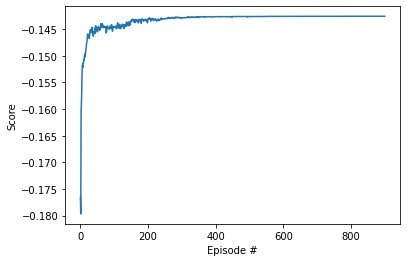

In [5]:
#Execute the cross entrophy method with default Values
#scores = cem()


#To don't ask the GPU as much reduce the pop_size, it's the amount of elemts try
scores,best_actions = cem_no_net()
# 
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
    

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


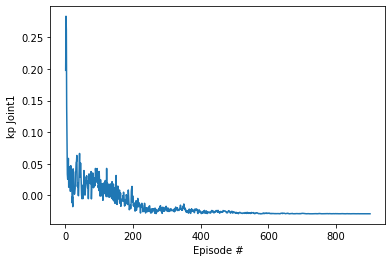

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


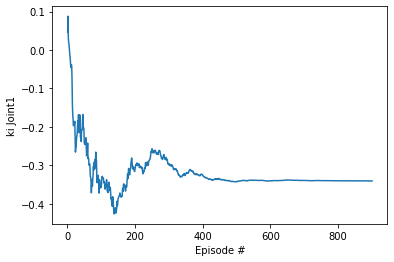

/home/sergi/anaconda3/envs/Train/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


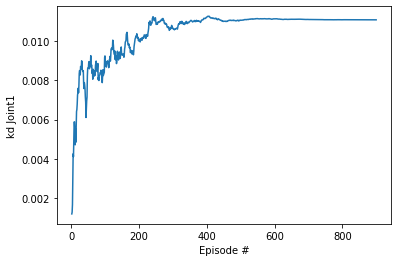

In [6]:
# plot actions
best_actions_np = np.array(best_actions)
joint = 1
for i in range(len(env.parameters_to_modify)) :
    parameter = env.parameters_to_modify[i]
    figures = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, best_actions_np.shape[0]+1), best_actions_np[:,joint+i*7])
    plt.ylabel(parameter+" Joint"+str(joint))
    plt.xlabel('Episode #')
    plt.show()

In [3]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excel_path_Okay_tcp = "./positions_from_joints_19.xlsx",time_step=0.05,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

env.update_parameters_to_modify(["mass","max_vel","kp","ki","damping","force_x_one","Ixx","Iyy","Izz"])
env.robot.visual_inspection = False
env.modified_parameters_df = env.create_df_from_Excel("./Parameters_train_tcp_euc_rishabh.xlsx")


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print(action)
reward = env.step_tcp_rishabh(action)



hola
../Simulation_Pybullet/models/urdf/JACO3_URDF_V11.urdf
Robot launched
hola
(7, 12)
(7, 17)
mass okey
max_vel okey
kp okey
ki okey
damping okey
force_x_one okey
Ixx okey
Iyy okey
Izz okey
[ 1.37735300e+00  1.16366700e+00  1.16366000e+00  9.30287000e-01
  6.78106000e-01  6.78106000e-01  5.00657000e-01  3.00000000e+01
  3.00000000e+01  3.00000000e+01  3.00000000e+01  3.00000000e+01
  3.00000000e+01  3.00000000e+01  6.05229874e-01 -2.89808887e-02
 -7.08317173e-01  9.97884990e-01  6.11117395e-01  1.60280001e-01
  6.42073890e-01 -1.20574595e+00 -3.40820763e-01  1.21703829e-01
 -7.39056632e-01  4.63158717e-01  2.65492678e-01 -1.60278708e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  4.80078221e-03  8.41872412e-03
  7.54451620e-03  6.40969196e-03  1.67978468e-03  1.93759353e-03
  7.75038580e-04  4.75519127

In [4]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Train_parameters_result_tcp_euc_rishabhv2.xlsx")

[-9.97990336e-03 -3.78506063e-03 -5.05500220e-04  2.29420797e-02
  5.41717782e-02  8.56396367e-02  1.04105867e-01  1.16808734e-01
  1.39861131e-01  1.66049200e-01  1.96505665e-01  2.28924722e-01
  2.52065245e-01  2.75757961e-01  2.95083807e-01  3.32350626e-01
  3.68511122e-01  4.05240309e-01  4.33067447e-01  4.68798527e-01
  4.88057366e-01  5.23693181e-01  5.43812348e-01  5.80063615e-01
  5.99660512e-01  6.38308914e-01  6.51311882e-01  6.84793132e-01
  6.68511497e-01  7.00923718e-01  6.82895837e-01  6.96405187e-01
  6.96758763e-01  6.99750038e-01  6.78104660e-01  6.58610419e-01
  6.40234149e-01  6.33666574e-01  6.18426683e-01  6.13236355e-01]


In [ ]:
env.original_parameters_df

In [ ]:
# load the weights from file
# Not working know


#state = env.reset()
env = env_pybullet_kin_gen3(no_zeros = True,Excel_path_Okay_tcp = "./positions_from_joints_19.xlsx",time_step=0.05,home_angles = [-0.207226464676801,1.5689993219813,-1.01515387451347,-2.45271819663908,2.00795352004673,1.91098991659003,-0.831045149646278])
env.robot.visual_inspection = False

#Make maxvels closer to the reality
#env.original_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]
env.modified_parameters_df ["max_vel"]=[168,151,128,94,210,48,189]

env.update_parameters_to_modify(["mass","max_vel","kp","ki","damping","force_x_one","Ixx","Iyy","Izz"])
env.robot.visual_inspection = False
env.modified_parameters_df = env.original_parameters_df


t.sleep(0.02)
action = env.action_modified()
action = np.array(action)
print(action)
reward = env.step_tcp_rishabh(action)

print("reward")
print(reward)

In [ ]:
#Convert to excel
a = env.df_avg.to_numpy()
print(a[:,5])
env.df_avg.to_excel("./Original_parameters_result_tcp_euc_rishabhv2.xlsx")